In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

df = pd.read_csv("../data/togo-dapaong_qc.csv",parse_dates=['Timestamp'])


In [2]:
df.head()

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


In [3]:
# 📊 Summary statistics of all numeric columns
summary_stats = df.describe()

# 🔍 Missing values count per column
missing_values = df.isna().sum()

#Identify columns with more than 5% missing values
missing_percentage = (missing_values / len(df)) * 100
columns_with_high_nulls = missing_percentage[missing_percentage > 5]

# Display results
print("Summary Statistics:\n", summary_stats)
print("\nMissing Values:\n", missing_values)
print("\nColumns with >5% missing values:\n", columns_with_high_nulls)

Summary Statistics:
                            Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-25 12:00:30.000000768     230.555040     151.258469   
min              2021-10-25 00:01:00     -12.700000       0.000000   
25%              2022-01-24 06:00:45      -2.200000       0.000000   
50%              2022-04-25 12:00:30       2.100000       0.000000   
75%              2022-07-25 18:00:15     442.400000     246.400000   
max              2022-10-25 00:00:00    1424.000000    1004.500000   
std                              NaN     322.532347     250.956962   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      116.444352     226.144375     219.568588      27.751788   
min         0.000000       0.000000       0.000000      14.900000   
25%         0.000000       0.000000       0.000000      24.200000   
50%

In [ ]:
# Drop completely empty column
df = df.drop(columns=["Comments"])

# Columns to check for outliers
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Compute Z-scores
z_scores = df[cols_to_check].apply(zscore)

# Identify rows with any Z-score greater than 3 in absolute value
outlier_mask = (z_scores.abs() > 3).any(axis=1)
outlier_count = outlier_mask.sum()

print(f"Number of outlier rows detected: {outlier_count}")

df_cleaned = df[~outlier_mask].copy()

df_cleaned.fillna(df_cleaned.median(numeric_only=True), inplace=True)

# Confirm clean shape
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")


Number of outlier rows detected: 9251
Cleaned DataFrame shape: (516349, 18)


In [19]:
df.to_csv("../data/togo-dapaong_clean.csv", index=False)

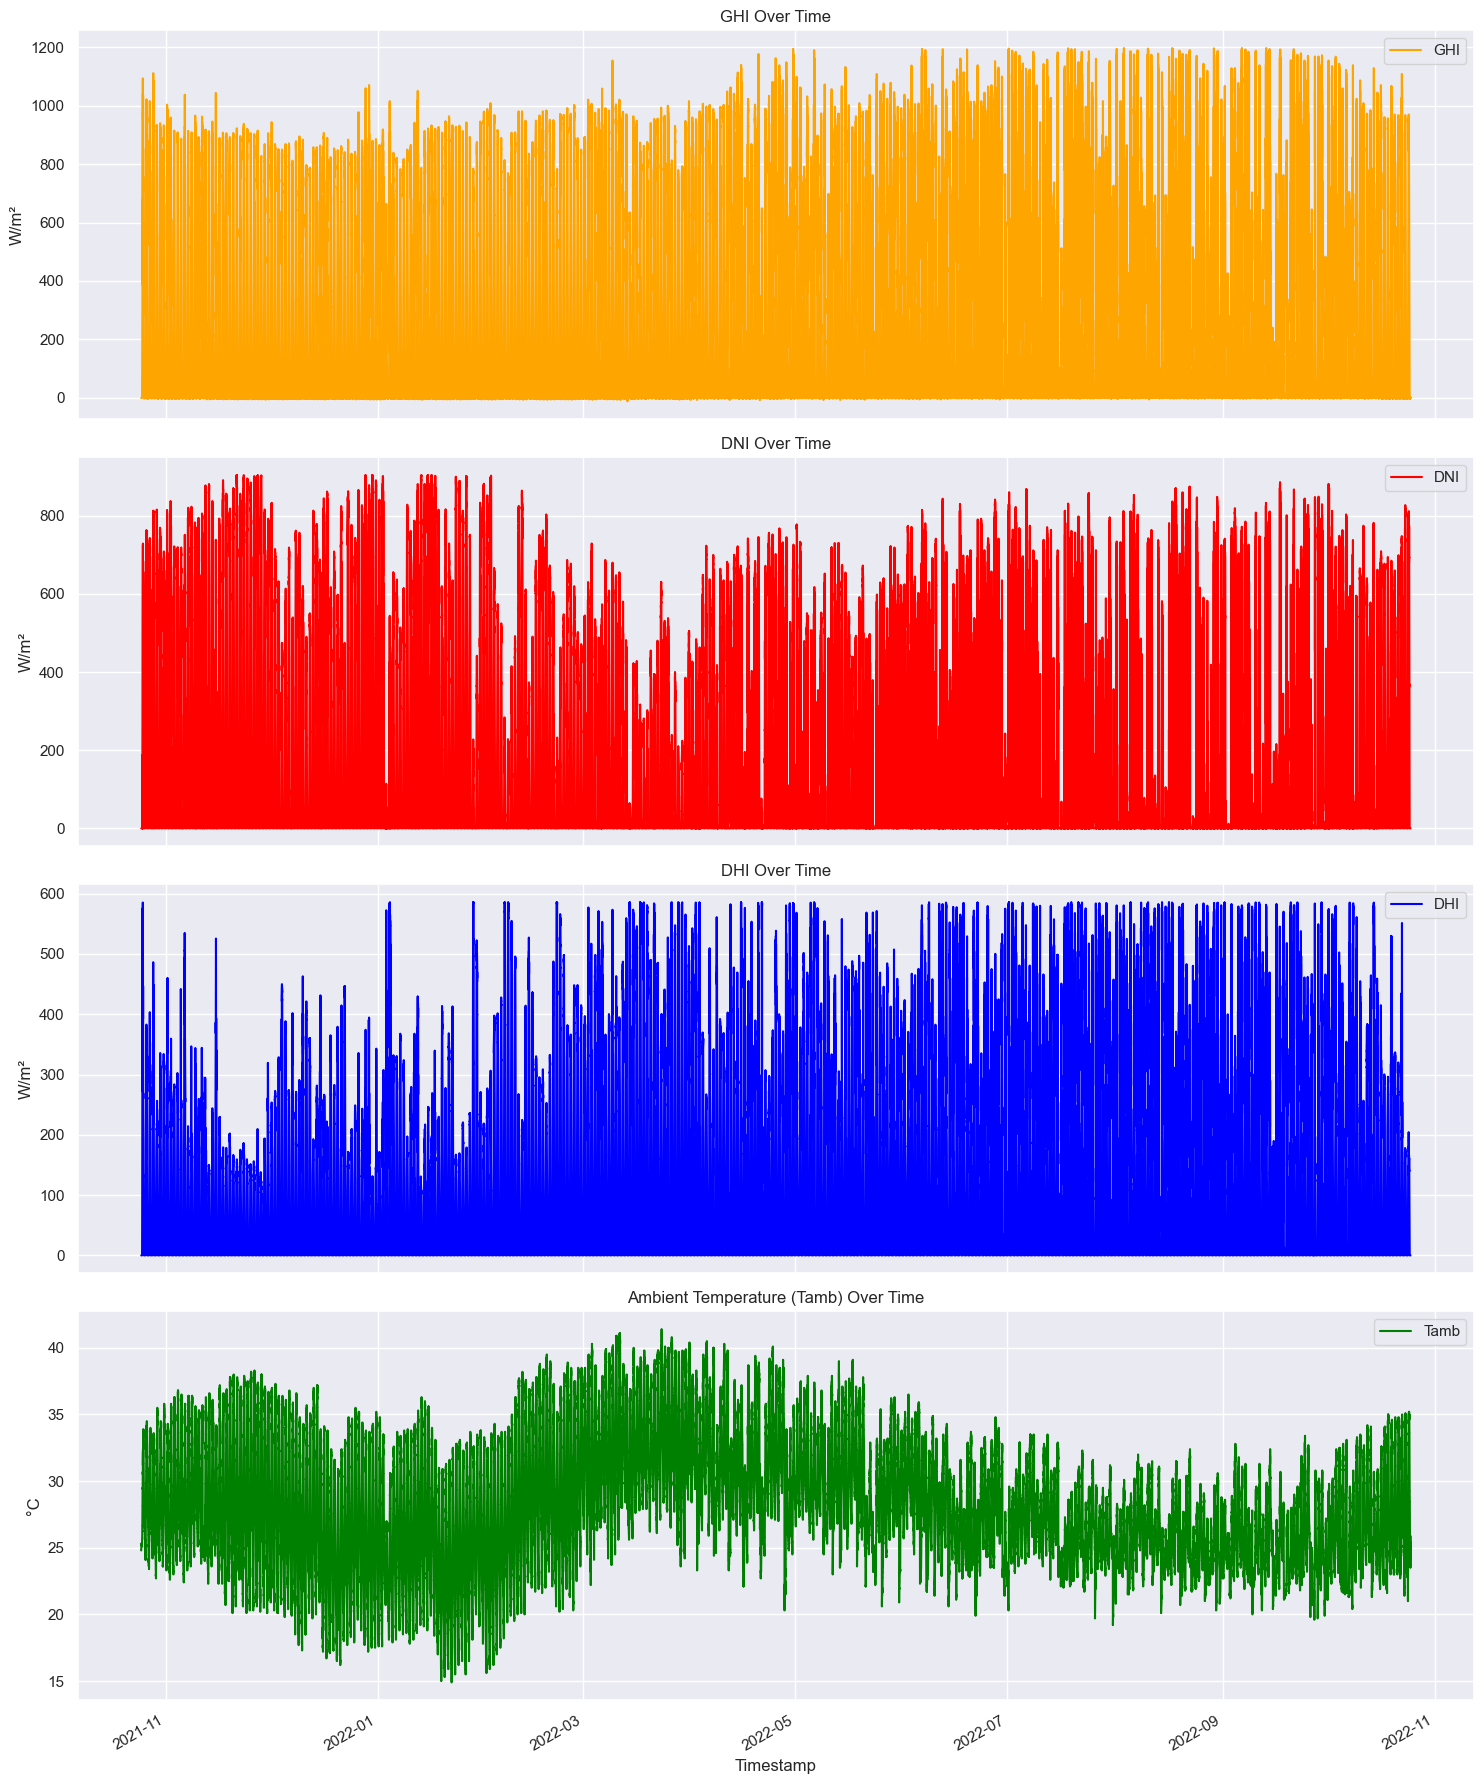

In [8]:

#Set the plotting style

sns.set_theme(rc={"figure.figsize": (15, 6)})

# Plot solar irradiance and temperature
fig, ax = plt.subplots(4, 1, figsize=(15, 18), sharex=True)

df_cleaned.set_index('Timestamp')[['GHI']].plot(ax=ax[0], color='orange')
ax[0].set_title("GHI Over Time")
ax[0].set_ylabel("W/m²")

df_cleaned.set_index('Timestamp')[['DNI']].plot(ax=ax[1], color='red')
ax[1].set_title("DNI Over Time")
ax[1].set_ylabel("W/m²")

df_cleaned.set_index('Timestamp')[['DHI']].plot(ax=ax[2], color='blue')
ax[2].set_title("DHI Over Time")
ax[2].set_ylabel("W/m²")

df_cleaned.set_index('Timestamp')[['Tamb']].plot(ax=ax[3], color='green')
ax[3].set_title("Ambient Temperature (Tamb) Over Time")
ax[3].set_ylabel("°C")
ax[3].set_xlabel("Timestamp")

plt.tight_layout()
plt.show()

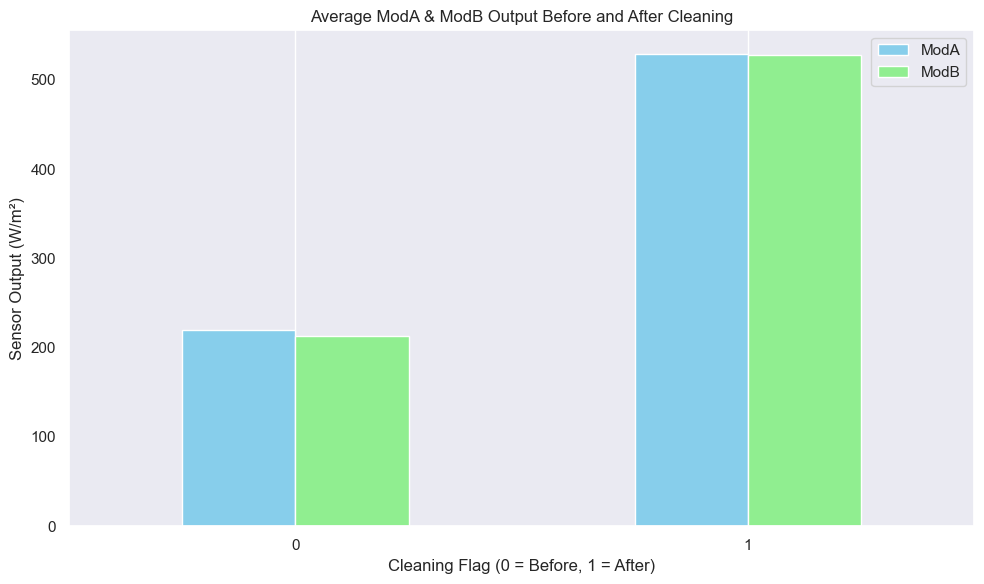

In [9]:
import matplotlib.pyplot as plt

# Group by cleaning flag and compute mean values
cleaning_grouped = df_cleaned.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plot
cleaning_grouped.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'lightgreen'])
plt.title("Average ModA & ModB Output Before and After Cleaning")
plt.xlabel("Cleaning Flag (0 = Before, 1 = After)")
plt.ylabel("Sensor Output (W/m²)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(["ModA", "ModB"])
plt.tight_layout()
plt.show()

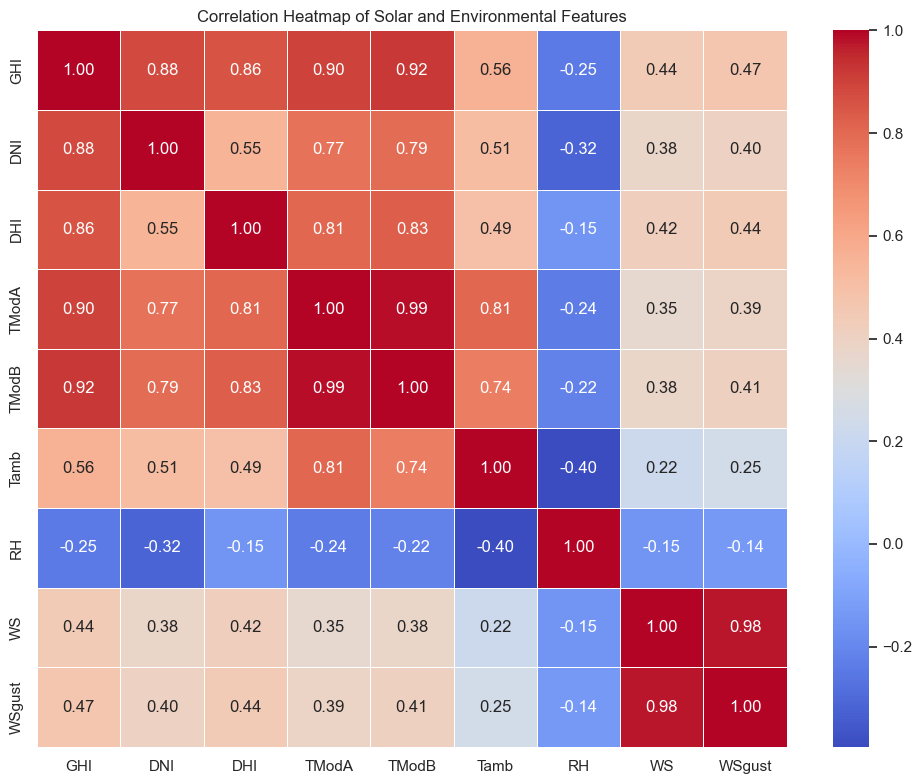

In [10]:
# Select relevant columns
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'WSgust']
corr_matrix = df_cleaned[corr_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Solar and Environmental Features")
plt.tight_layout()
plt.show()

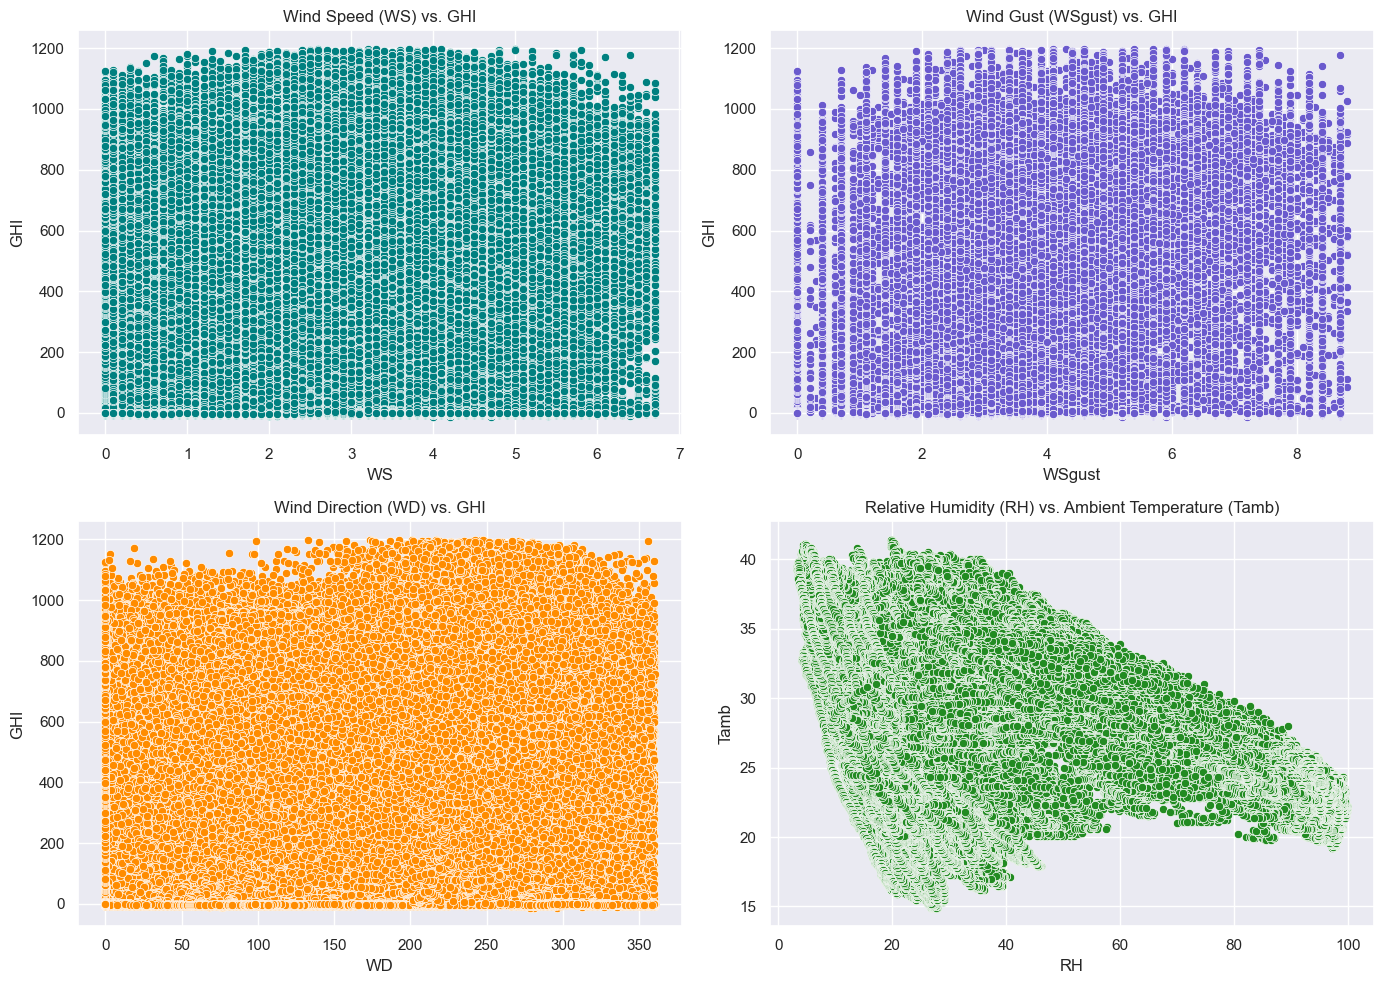

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# WS vs GHI
sns.scatterplot(data=df_cleaned, x='WS', y='GHI', ax=axs[0, 0], color='teal')
axs[0, 0].set_title("Wind Speed (WS) vs. GHI")

# WSgust vs GHI
sns.scatterplot(data=df_cleaned, x='WSgust', y='GHI', ax=axs[0, 1], color='slateblue')
axs[0, 1].set_title("Wind Gust (WSgust) vs. GHI")

# WD vs GHI
sns.scatterplot(data=df_cleaned, x='WD', y='GHI', ax=axs[1, 0], color='darkorange')
axs[1, 0].set_title("Wind Direction (WD) vs. GHI")

# RH vs Tamb
sns.scatterplot(data=df_cleaned, x='RH', y='Tamb', ax=axs[1, 1], color='forestgreen')
axs[1, 1].set_title("Relative Humidity (RH) vs. Ambient Temperature (Tamb)")

plt.tight_layout()
plt.show()

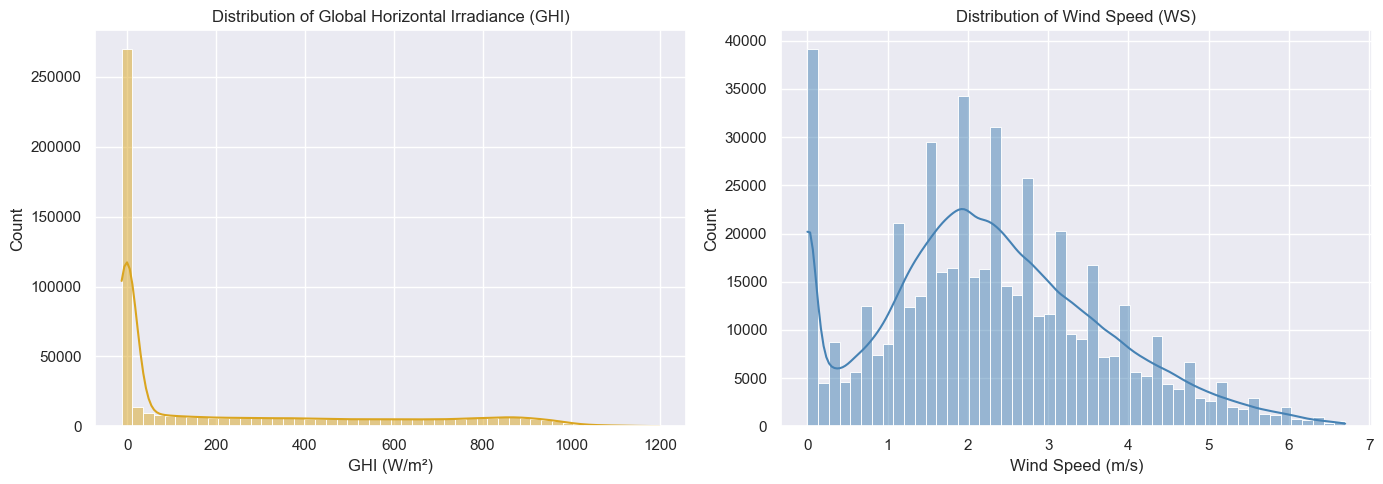

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histogram for GHI
sns.histplot(df_cleaned['GHI'], bins=50, kde=True, ax=axs[0], color='goldenrod')
axs[0].set_title("Distribution of Global Horizontal Irradiance (GHI)")
axs[0].set_xlabel("GHI (W/m²)")

# Histogram for Wind Speed
sns.histplot(df_cleaned['WS'], bins=50, kde=True, ax=axs[1], color='steelblue')
axs[1].set_title("Distribution of Wind Speed (WS)")
axs[1].set_xlabel("Wind Speed (m/s)")

plt.tight_layout()
plt.show()

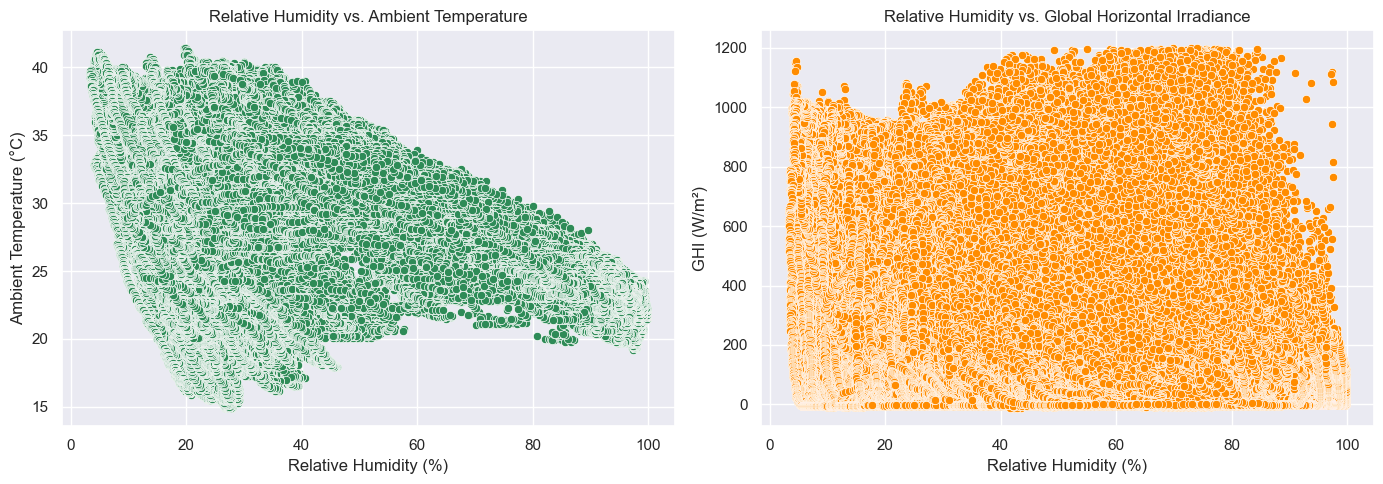

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# RH vs Tamb
sns.scatterplot(data=df_cleaned, x='RH', y='Tamb', ax=axs[0], color='seagreen')
axs[0].set_title("Relative Humidity vs. Ambient Temperature")
axs[0].set_xlabel("Relative Humidity (%)")
axs[0].set_ylabel("Ambient Temperature (°C)")

# RH vs GHI
sns.scatterplot(data=df_cleaned, x='RH', y='GHI', ax=axs[1], color='darkorange')
axs[1].set_title("Relative Humidity vs. Global Horizontal Irradiance")
axs[1].set_xlabel("Relative Humidity (%)")
axs[1].set_ylabel("GHI (W/m²)")

plt.tight_layout()
plt.show()

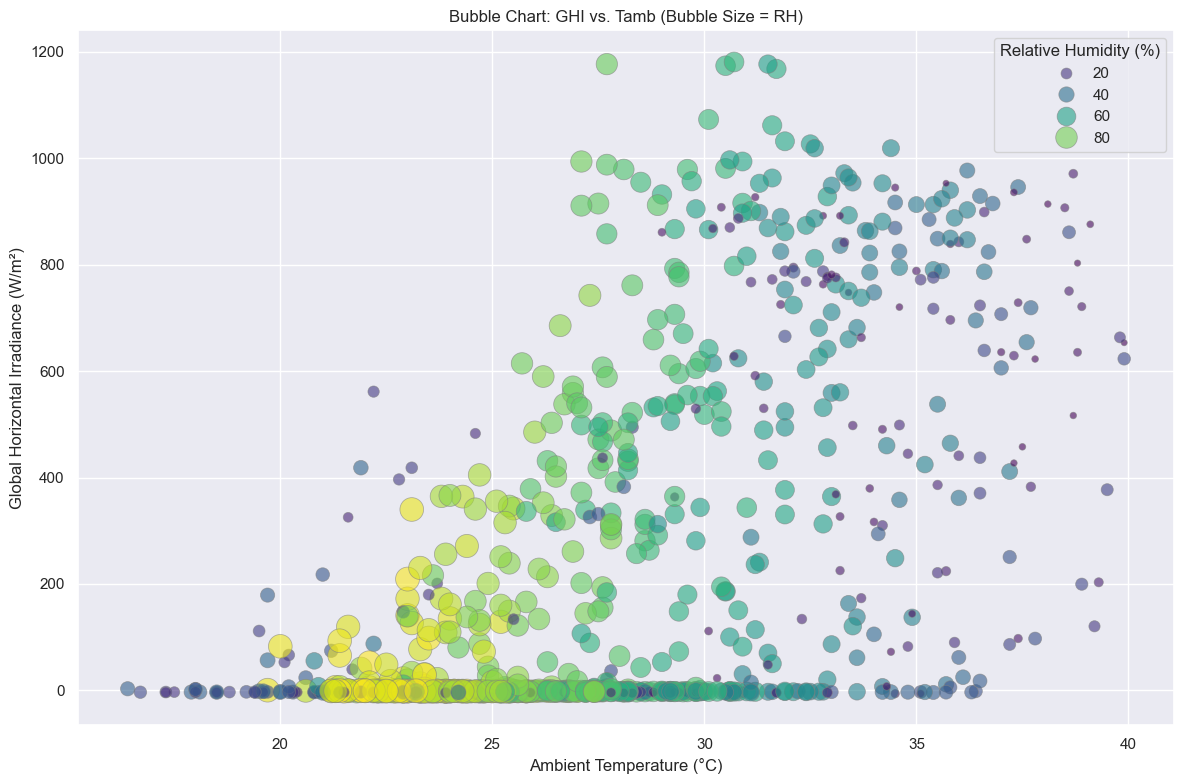

In [16]:
plt.figure(figsize=(12, 8))

# Use scatter plot with bubble size = RH
sns.scatterplot(
    data=df_cleaned.sample(1000, random_state=42),  # use a sample for readability
    x='Tamb',
    y='GHI',
    size='RH',
    hue='RH',
    palette='viridis',
    sizes=(20, 300),
    alpha=0.6,
    edgecolor="gray"
)

plt.title("Bubble Chart: GHI vs. Tamb (Bubble Size = RH)")
plt.xlabel("Ambient Temperature (°C)")
plt.ylabel("Global Horizontal Irradiance (W/m²)")
plt.legend(title='Relative Humidity (%)', loc='upper right')
plt.tight_layout()
plt.show()

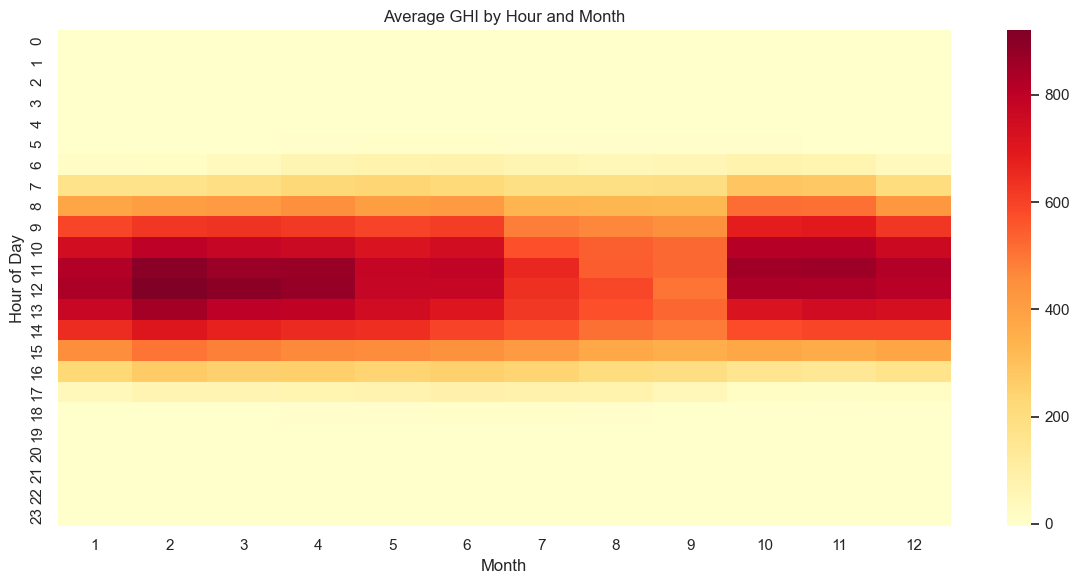

In [17]:
df_cleaned['Timestamp'] = pd.to_datetime(df_cleaned['Timestamp'])

# Extract hour and month
df_cleaned['Hour'] = df_cleaned['Timestamp'].dt.hour
df_cleaned['Month'] = df_cleaned['Timestamp'].dt.month

# Create pivot table
pivot = df_cleaned.pivot_table(index='Hour', columns='Month', values='GHI', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=False)
plt.title("Average GHI by Hour and Month")
plt.xlabel("Month")
plt.ylabel("Hour of Day")
plt.tight_layout()
plt.show()

<Axes: >

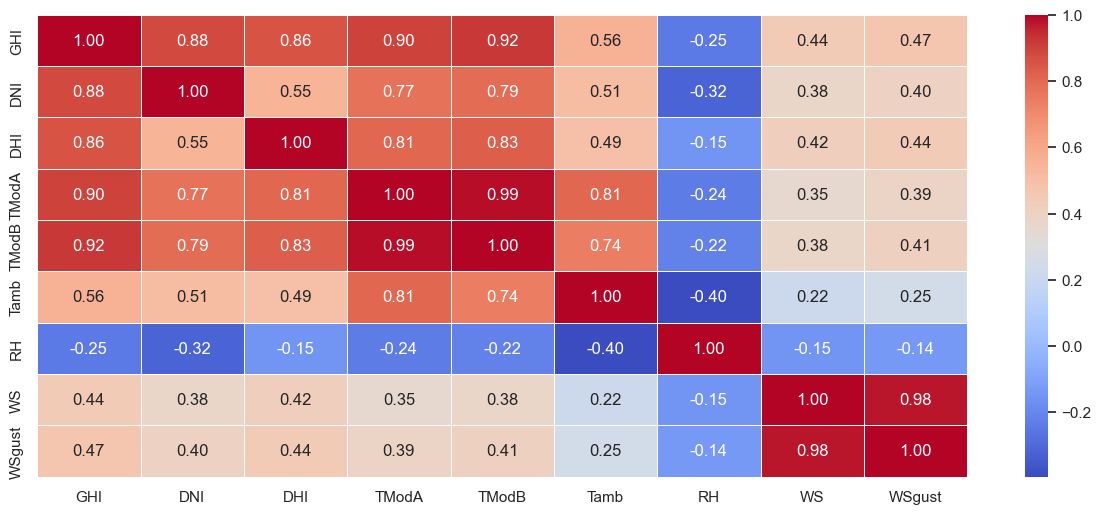

In [18]:
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)